In [1]:
import numpy as np
import matplotlib.pyplot as pplt
import aicsimage.processing as proc
from aicsimage.io import cziReader, omeTifReader, pngReader, tifReader, pngWriter, omeTifWriter
from scipy.ndimage.measurements import center_of_mass

# hides warnings from the tifReader
import warnings
warnings.filterwarnings('ignore')

def show(img, title=""):
    """
    Helper function to display a CYX image
    """
    # flip from CYX to YXC for pyplot
    pplt.imshow(img.transpose(1, 2, 0))
    pplt.title(title)
    pplt.show()
    
def load_all(*files):
    """
    Helper function to return list of images from file paths
    """
    images = []
    for f in files:
        with tifReader.TifReader(f) as r:
            images.append(r.load())
    return images

## Reading files

The aicsimage.io module has several classes for reading and writing images in different formats

They all behave similarly. Create a reader object of the appropriate type for the file, then use ```load()``` to copy the data to a numpy array. The output format depends on which reader you use

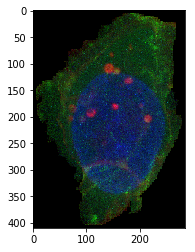

In [2]:
with tifReader.TifReader('test/img/img40_1_seg_cell.tif') as r:
    # img is now a greyscale ZYX numpy array
    img = r.load()
    
with omeTifReader.OmeTifReader('test/img/img40_1.ome.tif') as r:
    # img is now a TZCYZ numpy array
    img = r.load()

with pngReader.PngReader('test/img/img40_1.png') as r:
    # img is now a CYX image
    img = r.load()
    show(img)

### AicsImage
When reading CZI or OMETif files, you can also use the ```AicsImage``` class to easily read in an image in any shape. Just pass in the data and its current dimensions. The class takes care of expanding the image to any dimensions that may be missing from the input.

In [3]:
data4d = np.empty((3, 20, 20, 20))
# pass the current format in with the dims parameter
img4d = proc.AICSImage(data4d, dims="CZYX")
# use the get_image_data to get it out as a different format
# a single-layer T dimension is automatically added
img4dto5d = img4d.get_image_data("TZCYX")
print("TZCYX shape: ", img4dto5d.shape)
# any order or number of dimensions works
img4dto3d = img4d.get_image_data("XCT")
print("XCT shape: ", img4dto3d.shape)

TZCYX shape:  (1, 20, 3, 20, 20)
XCT shape:  (20, 3, 1)


When you leave out dimensions when using ```get_image_data```, it will select slice 0 from that dimension. You can use parameters to tell it to pick different slice indexes

In [4]:
# 2-channel CZYX image, channel 0 is all 0's, channel 1 is all 1's
data4d = np.stack([np.zeros((10, 10, 10)), np.ones((10, 10, 10))])
img4d = proc.AICSImage(data4d, dims="CZYX")
# by default gets C=0
chan1 = img4d.get_image_data("ZYX")
print(np.all(chan1 == 0))
# you can specify to get a different slice from the C channel, though
chan2 = img4d.get_image_data("ZYX", C=1)
print(np.all(chan2 == 1))

# you can do it for any number of dimensions
piece = img4d.get_image_data("XY", C=1, Z=5)

True
True


The class can also take in file paths to directly read images from disk

In [5]:
# dims doesn't need to be specified for files
img = proc.AICSImage("test/img/img40_1.ome.tif")
data = img.get_image_data("TCZYX")
print(data.shape)

(1, 5, 43, 410, 286)


## Writing Files
The library provides two classes to help with writing images out to file, and both behave similarly. 

In [6]:
# pass in the output file path and name
with pngWriter.PngWriter("test/sample/sample_out.png") as w:
    pass
    # pass a CYX array to w.save to actually write to disk
    # commented out to avoid actually doing this
    # w.save(numpy.ones((3, 10, 10)))
    
with omeTifWriter.OmeTifWriter("test/sample/sample_out.ome.tif") as w:
    pass
    # can be TCZYX, CZYX, or CYX
    # w.save(numpy.ones((3, 10, 10, 10)))

Both classes will throw an error if you attempt to overwrite an already-existing file. Set ```overwrite_file``` to True in order to overwrite a file

In [7]:
# overwriting is now enabled
with omeTifWriter.OmeTifWriter("test/sample/sample_out.ome.tif", overwrite_file=True) as w:
    pass
    # can be TCZYX, CZYX, or CYZ
    # w.save(numpy.ones((3, 10, 10, 10)))

# these classes also make file conversion very easy
# this converts a CZI and writes it as a OMETif in 3 lines

# img = proc.AICSImage('test/img/T=5_Z=3_CH=2_CZT_All_CH_per_Slice.czi')
# with omeTifWriter.OmeTifWriter("test/sample/czi_to.ome.tif") as w:
    # w.save(img.get_image_data("TCZYX"))

## Visualizing structures

In [8]:
# list of test images to use later on
images = load_all("test/sample/20160708_I01_001_1.ome.tif_cell.tif", "test/sample/20160708_I01_001_1.ome.tif_dna.tif", "test/sample/20160708_I01_001_1.ome.tif_memb.tif")
images = proc.crop_all(images)

### imgtoprojection(img, proj_all, proj_method, colors, global_adjust, color_adjust)

 This function can be used to combine multiple greyscale structures into a single projection, using the colors parameter to color each structure.
 
 Below is a typical test case, where multiple greyscale structures are colors and combined into a single XY projection 

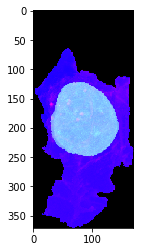

In [9]:
proj = proc.imgtoprojection(images, proj_method="max", colors="jet", local_adjust=True)
# proj can either be shown with matplotlib or written to disk with pngWriter
show(proj)

#### Options:

#### img
img can be any of the following:
* A single 4d numpy array as a CZYX image
* A list of 3d numpy arrays as ZYX images (the example above does this)
* A list of 2d numpy array as YX images

Either each channel in the 4d image or each image in the list will be colored by the ```colors``` parameter

#### proj_method
Method used to calculate the projections. Options are:
* max
       The default method, projections are usually bright and vivid
* mean
       Usually shows more detail but many structures may be too faint to see, cropping beforehand is recommended to brighten the images
* sum
       No real reason to use this one, usually gives similar results to mean
* slice
       Uses the middle slice as the projection, quickest to run


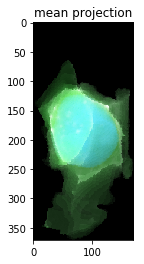

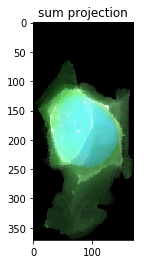

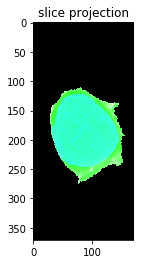

In [38]:
# the cell becomes less bright, but there is odd coloring in the nucleus where all of the
# channels overlap
proj = proc.imgtoprojection(images, proj_method="mean", colors="ocean", local_adjust=True)
show(proj, "mean projection")

# In this case, basically identical to the mean projection
proj = proc.imgtoprojection(images, proj_method="sum", colors="ocean", local_adjust=True)
show(proj, "sum projection")

# Shows the nucleus shape fine, but does not show the real shape of the total cell
proj = proc.imgtoprojection(images, proj_method="slice", colors="ocean", local_adjust=True)
show(proj, "slice projection")

#### proj_all
Boolean, default is False. If True, will output the XZ and the YZ projections as well as the XY in a grid

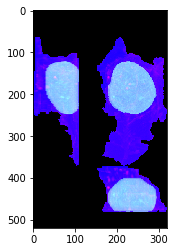

In [11]:
# same example as above, but now shows all three projections
# top left is the YZ projection
# top right is the XY projection
# bottom is the XZ projection
proj = proc.imgtoprojection(images, proj_all=True, colors="jet", local_adjust=True)
show(proj)

#### colors
colors can be one of three types:
* If a string, it will be passed as a parameter to the ```matplotlib.pyplot.get_cmap``` function to get the colors used for the projections. "jet" is a good default, as it will give a smooth rainbow spectrum
* If a function, it must take a single integer as a parameter (corresponding to the 0-based index of the channel to apply the color to) and return a list of three floats in the range of 0-1 to be used as the color for that channel
* If a list, must be a list of lists, which must be 3-element lists of numbers in the range of 0-1 to be used as the color for that channel

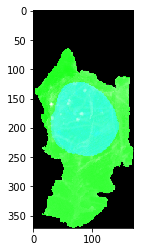

In [34]:
# uses the cmap function "ocean" (blues and greens and greys)
proj_str = proc.imgtoprojection(images, colors="ocean", local_adjust=True)
show(proj_str)

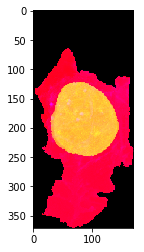

In [33]:
# example color function that cycles through red, blue, and green
def colors_func(i):
    c = [0, 0, 0]
    c[i % 3] = 1
    return c

proj_func = proc.imgtoprojection(images, colors=colors_func, local_adjust=True)
show(proj_func)
# the cell struture is turned red, the dna structure (very faint) is turned blue,
# and the nucleus is turned green (which mixes with the red cell to make yellow)

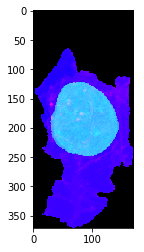

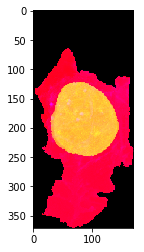

In [32]:
# green, blue, and red
color_list = [[0, 0, 1], [0, 1, 0], [1, 0, 0]]

proj_list = proc.imgtoprojection(images, colors=color_list, local_adjust=True)
show(proj_list)

# notice that the order the images are passed in affects which color is applies to which channel
proj_list = proc.imgtoprojection(images[::-1], colors=color_list, local_adjust=True)
show(proj_list)

#### local_adjust
Boolean value, default is false. If true, will perform contrast adjustment on each channel individually before it is added to the final combined projection. The contrast adjustment consists of subtracting the minimum value from the entire projection and dividing the whole thing by the maximum value.

Although it is off by default, it should be used in most cases, as it seems to dramatically improve image quality

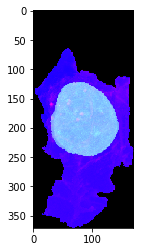

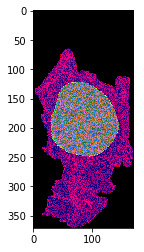

In [37]:
proj_list = proc.imgtoprojection(images, colors="jet", local_adjust=True)
show(proj_list)

# turning local_adjust off usually results in pixelated images
proj_list = proc.imgtoprojection(images, colors="jet", local_adjust=False)
show(proj_list)

## Image Manipulation

In [16]:
with omeTifReader.OmeTifReader("test/sample/20160708_I01_001_1.ome.tif_cell.tif") as r:
    cell = r.load()
with omeTifReader.OmeTifReader("test/sample/20160708_I01_001_1.ome.tif_nuc.tif") as r:
    nuc = r.load()
    
cell, nuc = proc.crop_all([cell, nuc])

### Rotation

```get_align_angles``` and ```align_major``` can be used to align 3d structures along an axis

```get_align_angles``` performs the calculations needed to rotate a 3d strcutre to align with the specified axes, and returns that data so that it can be passed in to ```align_major``` to perform the actual rotation

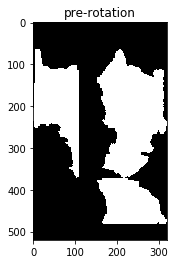

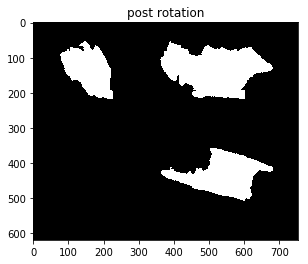

In [17]:
proj = proc.imgtoprojection(cell, proj_all=True)
show(proj, "pre-rotation")

# use the 'axes' parameter to choose which axes to align the structure to
angles = proc.get_align_angles(cell, "xyz")
# pass the angles to align_major to rotate the structure
cell_rot = proc.align_major(cell, angles)
proj = proc.imgtoprojection(cell_rot, proj_all=True)
show(proj, "post rotation")

The ```reshape``` parameter is a boolean, true by default. When true, it will reshape the output image in order to ensure that none of the data from the input image is lost. If false, the output image will be the same shape as the input image, but there is a good chance of cropping out important data.

The function can either take in a single image or a list of images in order to rotate multiple images in a single call by the same amount

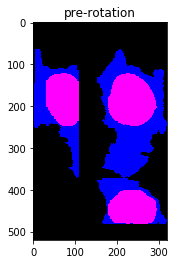

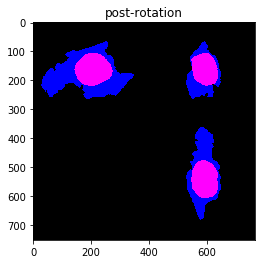

In [18]:
proj = proc.imgtoprojection([cell[0], nuc[0]], colors="jet", proj_all=True, local_adjust=True)
show(proj, "pre-rotation")

angles = proc.get_align_angles(cell, "zyx")
# if you pass in a list of images, it will return a list of the rotated images
cell_rot, nuc_rot = proc.align_major([cell, nuc], angles)

proj_rot = proc.imgtoprojection([cell_rot[0], nuc_rot[0]], colors="jet", proj_all=True, local_adjust=True)
show(proj_rot, "post-rotation")

The cell is rotated to align with the z axis, and the nucleus is rotated by the same amount to keep the two structures aligned with each other

### Centering
Use ```get_center_moves``` and ```center_image``` to center an image based on its center of mass.
It does this by padding the image, so the output image will always be larger than the input (unless no padding is needed)

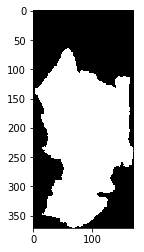

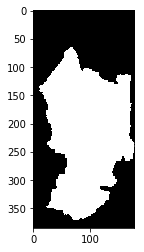

In [19]:
proj = proc.imgtoprojection(cell)
show(proj)

# get the moves needed from get_center_moves()
moves = proc.get_center_moves(cell)
# then pass them to center()
# this image was already pretty much centered
cell_cent= proc.center(cell, moves)
proj_cent = proc.imgtoprojection(cell_cent)
show(proj_cent)

Similar to ```align_major```, you can pass in a list of images and it will move them all by the same amount

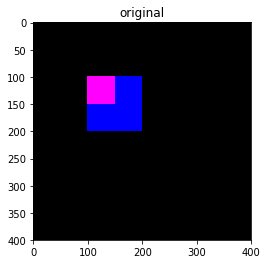

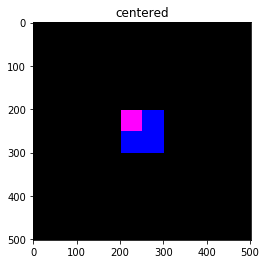

In [20]:
# example structures
big = np.zeros((1, 400, 400))
big[0, 100:200, 100:200] = 1
little = np.zeros((1, 400, 400))
little[0, 100:150, 100:150] = 1
proj = proc.imgtoprojection([big, little], colors="jet", local_adjust=True)
show(proj, "original")

# get the moves to center the big image
moves = proc.get_center_moves(big)
# move both images by the same amount
# centers the big image and moves the little one to stay aligned
big_cent, little_cent = proc.center([big, little], moves=moves)
proj_cent = proc.imgtoprojection([big_cent, little_cent], colors="jet", local_adjust=True)
show(proj_cent, "centered")

The centered structures appear smaller because the centered image is bigger due to the added padding

The ```axes``` parameter allows for the image to only be centered along certain axis. By default, the function will center align the last 3 axes of the passed in image (meant to be the Z, Y, and X axis). This can be used to only align along certain axes, like if you want it centered in the X and Y axis but not Z, or if you want to center an image with a different format, like a XYC image instead of a CZYX.

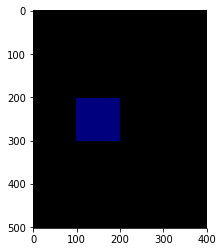

In [21]:
# same structure from previous example, only centered on Z and Y axis
moves = proc.get_center_moves(big, axes=(0, 1))
big_cent = proc.center(big, moves)
proj = proc.imgtoprojection([big_cent], colors="jet")
show(proj)

### Cropping

Since centering an image adds padding, cropping afterwards is usually recommended. The ```crop_all``` is the best way to do this after centering. It is meant to crop a group of images by the same amount, removing an equal amount from both ends of each axis that it crops on to ensure that the structures are still centered

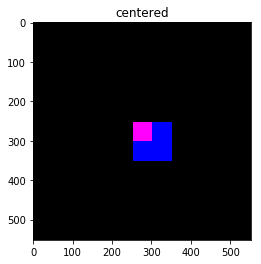

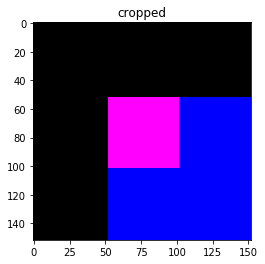

In [22]:
# centering by the little structure this time
moves = proc.get_center_moves(little)
big_cent, little_cent = proc.center([big, little], moves)
proj = proc.imgtoprojection([big_cent, little_cent], colors="jet", local_adjust=True)
show(proj, 'centered')


big_cropped, little_cropped = proc.crop_all([big_cent, little_cent])
proj_cropped = proc.imgtoprojection([big_cropped, little_cropped], colors="jet", local_adjust=True)
show(proj_cropped, "cropped")

The function cropped as much as it could without changing the center of mass or removing any data from either structure. The ```crop_all``` function also takes an ```axis``` parameter which lets it crop along any axis. By default, just like ```center_image```, it will act along the last 3 axis

If you do not care about keeping a structure centered, the ```crop``` function will crop off as much as it can from a  single image, with the option to leave some padding

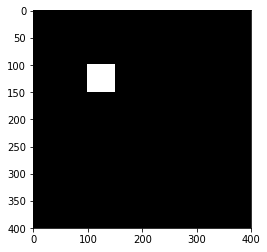

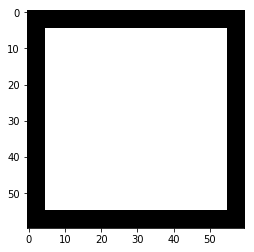

In [23]:
show(proc.imgtoprojection([little]))

little_crop = proc.crop(little, padding=5)

show(proc.imgtoprojection([little_crop]))

All but 5 pixels of padding was cropped from the image

### Background Subtraction
The processing library comes with some very basic background subtraction methods
The available methods are:
* mean,
    Subtract the mean value. This is the default method
* common,
    Subtract the most common value (calculated using scipy's ```mode``` function)
* median,
    Subtract the median value

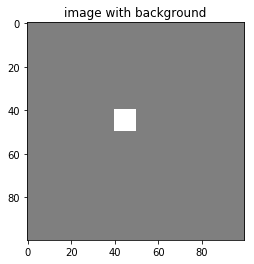

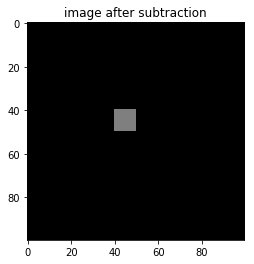

In [24]:
# test image, structure with a constant value background
img = np.empty((100, 100, 100))
img.fill(0.5)
img[40:50, 40:50, 40:50] = 1
show(proc.imgtoprojection([img]), "image with background")

# default method
res = proc.background_sub(img)
show(proc.imgtoprojection([res]), "image after subtraction")

The structure got darker as well because subtraction was performed on the entire image.

The function can also take in a mask. Background subtraction will be calculated on and performed on the area defined by the mask.

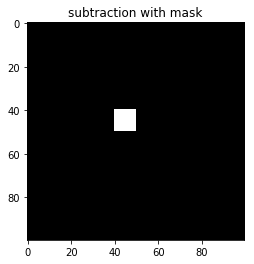

In [25]:
# everything outside of the square
mask = img < 1
# using mode subtraction this time
res = proc.background_sub(img, mask=mask, method="common")
show(proc.imgtoprojection([res]), "subtraction with mask")

The brightness of the structure was not affected this time since the mask caused the subtraction to only be performed on the actual background

### Resizing

#### resize
Use the ```resize``` function to scale an n-dimensional image by a specified factor

In [26]:
img = np.empty((3, 10, 10, 10))
# scale every axis by 2.5
res = proc.resize(img, 2.5)
print(res.shape)

(8, 25, 25, 25)


Usually, though, you just want to scale in the spatial dimensions. You can pass in a list or tuple to scale by different factors for different axis

In [27]:
# leave the color axis the same, double the Z axis, and halve the Y and X axes
res = proc.resize(img, (1, 2, 0.5, 0.5))
print(res.shape)

(3, 20, 5, 5)


The function supports three different interpolation methods to use when resizing: nearest neighbor, bilinear, and cubic interpolation. Nearest neighbor is default, but bilinear usually gives smoother and less pixelated images. Cubic is usually a poor choice for visuals

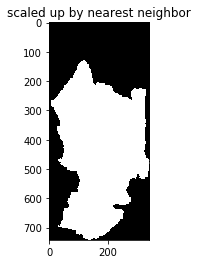

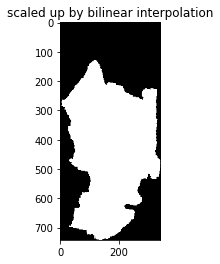

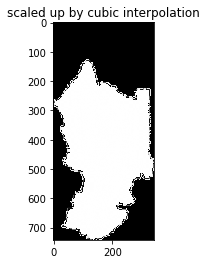

In [28]:
img = proc.imgtoprojection(cell)

big_img = proc.resize(img, (1, 2, 2))
show(big_img, "scaled up by nearest neighbor")
big_img = proc.resize(img, (1, 2, 2), "bilinear")
show(big_img, "scaled up by bilinear interpolation")
big_img = proc.resize(img, (1, 2, 2), "cubic")
show(big_img, "scaled up by cubic interpolation")

The image scaled with bilinear interpolation is noticably smoother on the edges

#### resize_to

This method is very similar to ```resize```, except it takes in the desired output size instead of the scaling factor. It supports the same interpolation methods as well

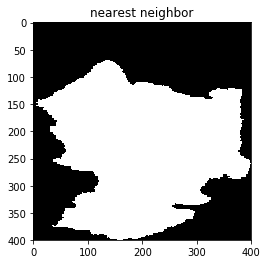

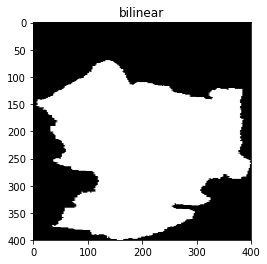

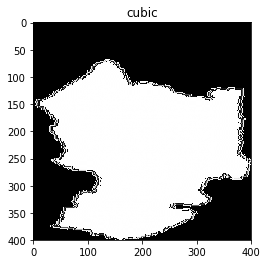

In [29]:
# scale it into a 400x400 image
res = proc.resize_to(img, (3, 400, 400))
show(res, "nearest neighbor")

res = proc.resize_to(img, (3, 400, 400), "bilinear")
show(res, "bilinear")

res = proc.resize_to(img, (3, 400, 400), "cubic")
show(res, "cubic")

### Flipping
Use ```get_flips``` and ```flip``` to flip multiple images to put their centers of mass in the desired quadrants. The usage is the same as aligning and centering, use ```get_flips``` to perform the calculations and ```flip``` to actually flip the images

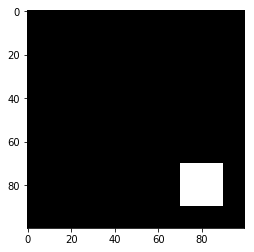

In [30]:
# example 3d cube
test_cube = np.zeros((1, 100, 100, 100))
test_cube[0, 70:90, 70:90, 70:90] = 1
img = proc.imgtoprojection(test_cube)
show(img)

The center of mass (COM) of the structure is at the center of the cube in the upper half of each dimension (Z, Y, and X). 

#### get_flips
The function takes 3 parameters, the first just being the image to use for calculations

The second parameter of ```get_flips``` is a string which tells the function which side of an axis the COM should be on, '-' meaning the lower half and '+' meaning the upper half

The third parameter tells the function which axes to calculate flips for, which by default is the last 3 spatial axes. 

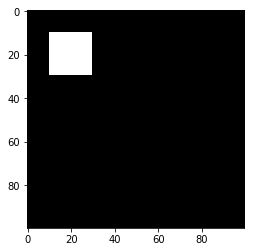

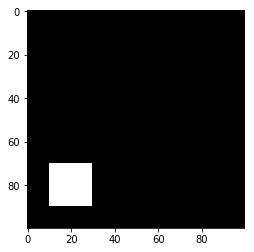

In [31]:
# flip the image to place the COM in the lower half of each axis
flips = proc.get_flips(test_cube, "---", axes=(-3, -2, -1))
test_flipped = proc.flip(test_cube, flips)
img = proc.imgtoprojection(test_flipped)
show(img)

# place the COM in the lower half of the X axis (the last one) but ignore the other axes
flips = proc.get_flips(test_cube, "-", axes=(-1,))
test_flipped = proc.flip(test_cube, flips)
img = proc.imgtoprojection(test_flipped)
show(img)

The first image was flipped to place the COM in the lower half of each axis (including the Z axis, although that is not apparent by the above projection)

The second was flipped to place the COM in the lower half of just the X axis, but did not do anything about the Y or Z axes

The ```flip``` function can also take in a list or tuple of images to flip them all the same way

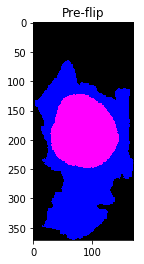

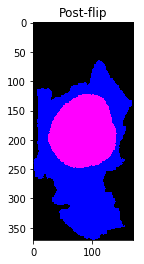

In [49]:
proj = proc.imgtoprojection([cell[0], nuc[0]], colors="jet", proj_method="max", local_adjust=True)
show(proj, "Pre-flip")

flips = proc.get_flips(cell, "+++")
cell_flipped, nuc_flipped = proc.flip([cell, nuc], flips)

proj = proc.imgtoprojection([cell_flipped[0], nuc_flipped[0]], colors="jet", proj_method="max", local_adjust=True)
show(proj, "Post-flip")

The flips were calculated based on the cell structure, and both structures were flipped to keep them aligned